# Global Terrorism Database -- Region Classifier

In [1]:
import tensorflow as tf
import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
import seaborn as sn
import os
import tempfile
import matplotlib.pylab as plt

### Read in cleaned data

In [2]:
df = pd.read_csv('gtdb(clean).csv', encoding = "ISO-8859-1") #read in cleaned dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159670 entries, 0 to 159669
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       159670 non-null  int64  
 1   iyear            159670 non-null  int64  
 2   imonth           159670 non-null  float64
 3   country          159670 non-null  int64  
 4   country_txt      159670 non-null  object 
 5   region           159670 non-null  int64  
 6   provstate        157317 non-null  object 
 7   city             159670 non-null  object 
 8   location         49419 non-null   object 
 9   summary          101152 non-null  object 
 10  success          159670 non-null  int64  
 11  suicide          159670 non-null  int64  
 12  attacktype1_txt  159670 non-null  object 
 13  targtype1_txt    159670 non-null  object 
dtypes: float64(1), int64(6), object(7)
memory usage: 17.1+ MB


In [3]:
encoder = sk.preprocessing.LabelEncoder() #use LabelEncoder to change text variables to numbers
df.head()

,Unnamed: 0,iyear,imonth,country,country_txt,region,provstate,city,location,summary,success,suicide,attacktype1_txt,targtype1_txt
0,0,1970,7.0,58,Dominican Republic,2,NaN,Santo Domingo,NaN,NaN,1,0,Assassination,Private Citizens & Property
1,3,1970,1.0,78,Greece,8,Attica,Athens,NaN,NaN,1,0,Bombing/Explosion,Government (Diplomatic)
2,4,1970,1.0,101,Japan,4,Fukouka,Fukouka,NaN,NaN,1,0,Facility/Infrastructure Attack,Government (Diplomatic)
3,5,1970,1.0,217,United States,1,Illinois,Cairo,NaN,1/1/1970: Unknown African American assailants ...,1,0,Armed Assault,Police
4,6,1970,1.0,218,Uruguay,3,Montevideo,Montevideo,NaN,NaN,0,0,Assassination,Police


In [4]:
encoder.fit(df['country_txt'])
df['country_txt'] = encoder.transform(df['country_txt'])
encoder.fit(df['city'])
df['city'] = encoder.transform(df['city'])
encoder.fit(df['attacktype1_txt'])
df['attacktype1_txt'] = encoder.transform(df['attacktype1_txt'])
encoder.fit(df['targtype1_txt'])
df['targtype1_txt'] = encoder.transform(df['targtype1_txt'])
df.head() #converted all relevant text variables to numbers

,Unnamed: 0,iyear,imonth,country,country_txt,region,provstate,city,location,summary,success,suicide,attacktype1_txt,targtype1_txt
0,0,1970,7.0,58,46,2,NaN,26427,NaN,NaN,1,0,1,13
1,3,1970,1.0,78,66,8,Attica,2224,NaN,NaN,1,0,2,5
2,4,1970,1.0,101,88,4,Fukouka,10021,NaN,NaN,1,0,3,5
3,5,1970,1.0,217,185,1,Illinois,5624,NaN,1/1/1970: Unknown African American assailants ...,1,0,0,12
4,6,1970,1.0,218,186,3,Montevideo,20153,NaN,NaN,0,0,1,12


### Select input attributes

In [5]:
new_df = df[["iyear", 'imonth', 'country','region','city','success','suicide', 'attacktype1_txt', 'targtype1_txt']].copy()
new_df.head()

,iyear,imonth,country,region,city,success,suicide,attacktype1_txt,targtype1_txt
0,1970,7.0,58,2,26427,1,0,1,13
1,1970,1.0,78,8,2224,1,0,2,5
2,1970,1.0,101,4,10021,1,0,3,5
3,1970,1.0,217,1,5624,1,0,0,12
4,1970,1.0,218,3,20153,0,0,1,12


### Count records of each class
Observed that there are major and minor classes in the dataset, and the model tends to classify the records into major classes to get a appearingly high accuracy. This will be checked after the evaluation.

In [11]:
df['region'].value_counts() #get total count of each region to compare accuracy.

# 1 = North America
# 2 = Central America & Caribbean
# 3 = South America
# 4 = East Asia
# 5 = Southeast Asia
# 6 = South Asia
# 7 = Central Asia
# 8 = Western Europe
# 9 = Eastern Europe
# 10 = Middle East & North Africa
# 11 = Sub-Saharan Africa
# 12 = Australasia & Oceania

10    44109
6     38820
3     16910
8     15393
11    15095
5     10746
2      8989
9      4792
1      3353
4       694
7       512
12      257
Name: region, dtype: int64

### Obtain train data and test data

In [17]:
labels = new_df['region'] #region
sets = new_df.iloc[:, [0,1,2,4,5,6,7,8]]

X = sets
y = np.ravel(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)  
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42) 
print(X)
print(y)

        iyear  imonth  country   city  success  suicide  attacktype1_txt  \
0        1970     7.0       58  26427        1        0                1   
1        1970     1.0       78   2224        1        0                2   
2        1970     1.0      101  10021        1        0                3   
3        1970     1.0      217   5624        1        0                0   
4        1970     1.0      218  20153        0        0                1   
...       ...     ...      ...    ...      ...      ...              ...   
159665   2017    12.0        4  19349        1        0                2   
159666   2017    12.0      182   6101        1        0                0   
159667   2017    12.0      200  12931        1        0                2   
159668   2017    12.0      160  16086        1        0                3   
159669   2017    12.0       92  12604        0        0                2   

        targtype1_txt  
0                  13  
1                   5  
2              

### Construct and compile the model

In [7]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, 8)),  # input layer
    keras.layers.Dense(640, activation='relu'),
    keras.layers.Dense(480, activation='relu'),
    keras.layers.Dense(320, activation='relu'),
    keras.layers.Dense(160, activation='relu'),
    keras.layers.Dense(80, activation='relu'),# hidden layers
    keras.layers.Dense(13, activation='softmax') # output layer
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']) #initial model, no biases, no normalization

### Fit the model to test data
Here a small number of epochs is used as the loss is observed to converge early.

In [8]:
history = model.fit(X_train, y_train,epochs=500, batch_size=2000, verbose=1, validation_data = (X_val, y_val))

Epoch 1/500
72/72 [==============================] - 2s 26ms/step - loss: 136.9809 - accuracy: 0.1882 - val_loss: 13.9021 - val_accuracy: 0.2805
Epoch 2/500
72/72 [==============================] - 2s 23ms/step - loss: 13.2889 - accuracy: 0.2259 - val_loss: 6.7790 - val_accuracy: 0.1797
Epoch 3/500
72/72 [==============================] - 2s 27ms/step - loss: 6.6288 - accuracy: 0.2441 - val_loss: 8.9341 - val_accuracy: 0.2818
Epoch 4/500
72/72 [==============================] - 2s 23ms/step - loss: 4.8810 - accuracy: 0.2588 - val_loss: 2.2051 - val_accuracy: 0.2952
Epoch 5/500
72/72 [==============================] - 2s 27ms/step - loss: 2.1850 - accuracy: 0.3207 - val_loss: 2.4904 - val_accuracy: 0.3616
Epoch 6/500
72/72 [==============================] - 2s 26ms/step - loss: 2.0362 - accuracy: 0.3417 - val_loss: 1.7796 - val_accuracy: 0.3776
Epoch 7/500
72/72 [==============================] - 2s 25ms/step - loss: 1.7972 - accuracy: 0.3686 - val_loss: 1.7515 - val_accuracy: 0.3538
Ep

72/72 [==============================] - 2s 25ms/step - loss: 1.0543 - accuracy: 0.6438 - val_loss: 1.1013 - val_accuracy: 0.6143
Epoch 111/500
72/72 [==============================] - 2s 25ms/step - loss: 1.0644 - accuracy: 0.6391 - val_loss: 1.0201 - val_accuracy: 0.6622
Epoch 112/500
72/72 [==============================] - 2s 25ms/step - loss: 1.0747 - accuracy: 0.6359 - val_loss: 0.9739 - val_accuracy: 0.6691
Epoch 113/500
72/72 [==============================] - 2s 25ms/step - loss: 1.0569 - accuracy: 0.6449 - val_loss: 0.9527 - val_accuracy: 0.6841
Epoch 114/500
72/72 [==============================] - 2s 25ms/step - loss: 1.0229 - accuracy: 0.6565 - val_loss: 0.9493 - val_accuracy: 0.6731
Epoch 115/500
72/72 [==============================] - 2s 25ms/step - loss: 1.0267 - accuracy: 0.6526 - val_loss: 1.3125 - val_accuracy: 0.6299
Epoch 116/500
72/72 [==============================] - 2s 26ms/step - loss: 1.0568 - accuracy: 0.6439 - val_loss: 0.9365 - val_accuracy: 0.6828
Epoch 

Epoch 167/500
72/72 [==============================] - 2s 28ms/step - loss: 0.5955 - accuracy: 0.8051 - val_loss: 0.5959 - val_accuracy: 0.8006
Epoch 168/500
72/72 [==============================] - 2s 28ms/step - loss: 0.5802 - accuracy: 0.8085 - val_loss: 0.5713 - val_accuracy: 0.8319
Epoch 169/500
72/72 [==============================] - 2s 28ms/step - loss: 0.6069 - accuracy: 0.8039 - val_loss: 0.5013 - val_accuracy: 0.8475
Epoch 170/500
72/72 [==============================] - 2s 28ms/step - loss: 0.6065 - accuracy: 0.7959 - val_loss: 0.4880 - val_accuracy: 0.8519
Epoch 171/500
72/72 [==============================] - 2s 28ms/step - loss: 0.5716 - accuracy: 0.8103 - val_loss: 0.4857 - val_accuracy: 0.8563
Epoch 172/500
72/72 [==============================] - 2s 29ms/step - loss: 0.5919 - accuracy: 0.8034 - val_loss: 0.5365 - val_accuracy: 0.8350
Epoch 173/500
72/72 [==============================] - 2s 28ms/step - loss: 0.5529 - accuracy: 0.8182 - val_loss: 0.4786 - val_accuracy:

Epoch 224/500
72/72 [==============================] - 2s 29ms/step - loss: 0.4647 - accuracy: 0.8536 - val_loss: 0.4665 - val_accuracy: 0.8594
Epoch 225/500
72/72 [==============================] - 2s 28ms/step - loss: 0.5617 - accuracy: 0.8141 - val_loss: 0.4484 - val_accuracy: 0.8544
Epoch 226/500
72/72 [==============================] - 2s 28ms/step - loss: 0.4954 - accuracy: 0.8419 - val_loss: 0.6693 - val_accuracy: 0.7693
Epoch 227/500
72/72 [==============================] - 2s 27ms/step - loss: 0.4981 - accuracy: 0.8377 - val_loss: 0.4155 - val_accuracy: 0.8682
Epoch 228/500
72/72 [==============================] - 2s 29ms/step - loss: 0.4579 - accuracy: 0.8517 - val_loss: 0.3864 - val_accuracy: 0.8845
Epoch 229/500
72/72 [==============================] - 2s 30ms/step - loss: 0.4984 - accuracy: 0.8350 - val_loss: 0.3918 - val_accuracy: 0.8785
Epoch 230/500
72/72 [==============================] - 2s 28ms/step - loss: 0.4903 - accuracy: 0.8363 - val_loss: 0.5408 - val_accuracy:

Epoch 337/500
72/72 [==============================] - 2s 29ms/step - loss: 0.2868 - accuracy: 0.9065 - val_loss: 0.2681 - val_accuracy: 0.9167
Epoch 338/500
72/72 [==============================] - 2s 27ms/step - loss: 0.3078 - accuracy: 0.8975 - val_loss: 0.3917 - val_accuracy: 0.8604
Epoch 339/500
72/72 [==============================] - 2s 33ms/step - loss: 0.4312 - accuracy: 0.8636 - val_loss: 0.2795 - val_accuracy: 0.9123
Epoch 340/500
72/72 [==============================] - 2s 31ms/step - loss: 0.2769 - accuracy: 0.9082 - val_loss: 0.2666 - val_accuracy: 0.9177
Epoch 341/500
72/72 [==============================] - 2s 30ms/step - loss: 0.4746 - accuracy: 0.8514 - val_loss: 0.2830 - val_accuracy: 0.9152
Epoch 342/500
72/72 [==============================] - 2s 26ms/step - loss: 0.2862 - accuracy: 0.9074 - val_loss: 0.2706 - val_accuracy: 0.9170
Epoch 343/500
72/72 [==============================] - 2s 27ms/step - loss: 0.2984 - accuracy: 0.9007 - val_loss: 0.2630 - val_accuracy:

Epoch 450/500
72/72 [==============================] - 2s 27ms/step - loss: 0.7756 - accuracy: 0.8037 - val_loss: 0.9677 - val_accuracy: 0.7054
Epoch 451/500
72/72 [==============================] - 2s 27ms/step - loss: 0.6550 - accuracy: 0.7863 - val_loss: 0.5178 - val_accuracy: 0.8341
Epoch 452/500
72/72 [==============================] - 2s 26ms/step - loss: 0.4916 - accuracy: 0.8371 - val_loss: 0.4734 - val_accuracy: 0.8425
Epoch 453/500
72/72 [==============================] - 2s 27ms/step - loss: 0.4543 - accuracy: 0.8483 - val_loss: 0.4404 - val_accuracy: 0.8557
Epoch 454/500
72/72 [==============================] - 2s 26ms/step - loss: 0.4298 - accuracy: 0.8621 - val_loss: 1.5144 - val_accuracy: 0.6252
Epoch 455/500
72/72 [==============================] - 2s 27ms/step - loss: 0.7204 - accuracy: 0.7781 - val_loss: 0.4194 - val_accuracy: 0.8763
Epoch 456/500
72/72 [==============================] - 2s 28ms/step - loss: 0.3931 - accuracy: 0.8758 - val_loss: 0.3915 - val_accuracy:

### Evaluate the model on test data

In [9]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=1) 

print('Test accuracy:', test_acc)

400/400 [==============================] - 0s 956us/step - loss: 0.4640 - accuracy: 0.8356
Test accuracy: 0.8355907201766968


### Plot confusion matrix of test data
This step is necessary as it can show if the model actually predicts records in minor classes.

In [10]:
modelPredict = model.predict(X_test, batch_size = 10, verbose = 0)
cm = sk.metrics.confusion_matrix(y_test, modelPredict.argmax(axis = -1))

AxesSubplot(0.125,0.125;0.62x0.755)


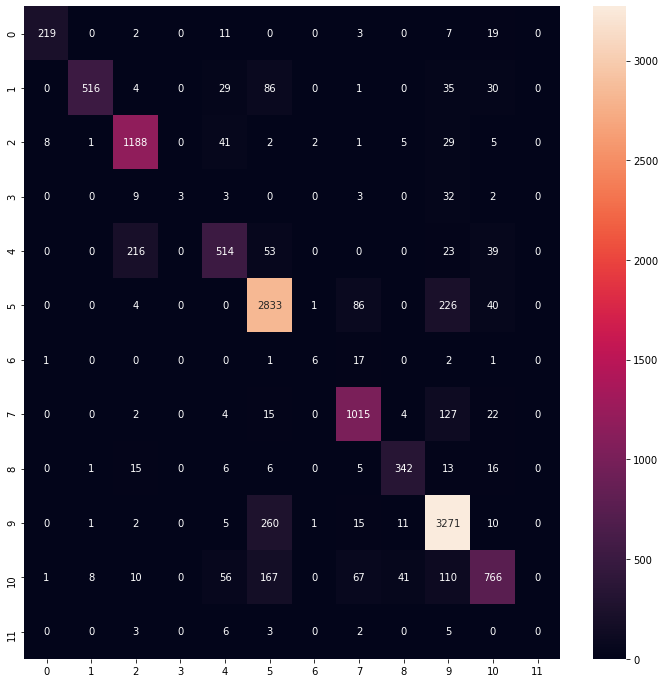

In [12]:
plt.figure(figsize = (12,12))
region_plot = sn.heatmap(cm,annot=True, annot_kws={"size": 10},fmt='d')
print(region_plot)
region_plot.figure.savefig("Region Prediction Heatmap.png") #to save as picture. Can comment out

### Plot accuracy and loss graphs

In [13]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


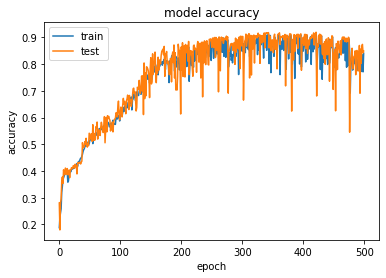

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show() #plot accuracy graph over time

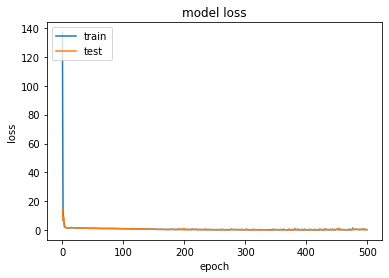

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show() #plot loss curve